# Machine Learning Engineer Nanodegree - Capstone Project

The solution to the Kaggle Challenge [LANL Earthquake Prediction](https://www.kaggle.com/c/LANL-Earthquake-Prediction) as part of the Capstone project for the Machine Learning Engineer.

This notebook contains the code to solve the problem as well as several visualizations to display the data better. In this project machine learning algorithms from Scikit were used as well as Keras to solve the problem with a neural network.


## Instructions

Follow the instructions in the [README Data](https://github.com/tobiassteidle/MLND_Capstone/tree/master/data) to download the training and test data for the project.

##### Additional Python scripts:  
utils.py: Help functions for reading files or processing the data  
visualize.py: Functions for Plotting Data

All cells can be executed one after the other. At the end, a sumbission.csv file is created which can be transferred to Kaggle to solve the project.

## Implementation

#### Import dependencies and set common constants

In [1]:
import os
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm_notebook as tqdm
from visualize import *
from utils import *
from denoise import *
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
from tensorflow import set_random_seed

pd.options.display.precision = 15

train_data_file = './data/train.csv'
test_file_dir = './data/test/'

CHUNK_SIZE = 150000
SUBSET_SIZE = 60000000

n_mfcc=10 # Anzahl der MFCC Features
#sample_rate=3851000
sample_rate=44100

seed = 1234
np.random.seed(seed)
set_random_seed(seed)

#### Load the data from the CSV

In [2]:
seismic_data  = pd.read_csv(train_data_file, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

acoustic_data = seismic_data.acoustic_data.values.astype('float32')
time_to_failure = seismic_data.time_to_failure.values.astype('float32')

## Data Exploration

#### Number of records + example of top 5 data

In [3]:
print("Total rows in dataset: %d" % len(seismic_data)) 
print("Top 5 rows:")
seismic_data.head(5)

Total rows in dataset: 629145480
Top 5 rows:


,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


#### Visualization of a chunk of the acoustic data with corresponding time_to_failure

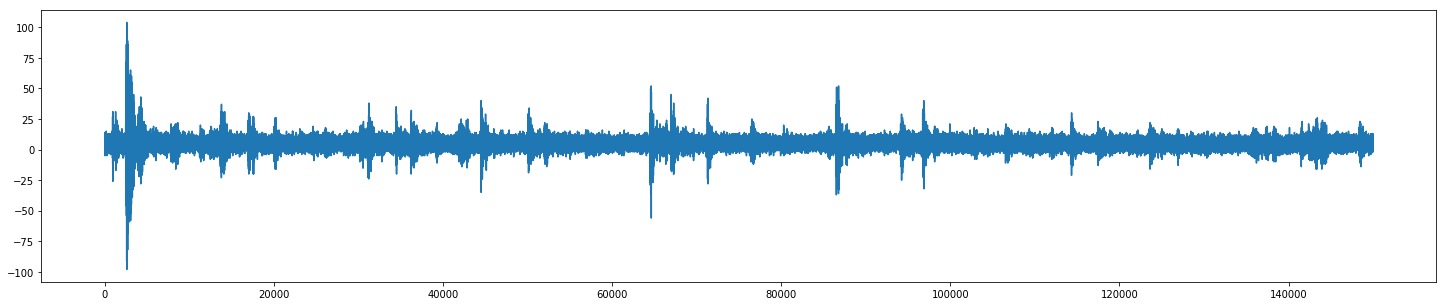

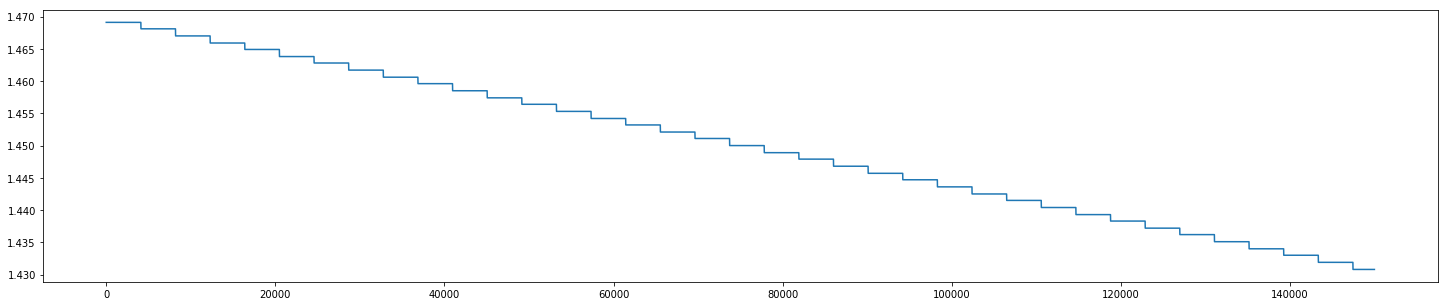

In [4]:
plot_dataset(acoustic_data[:CHUNK_SIZE])
plot_dataset(time_to_failure[:CHUNK_SIZE])

#### MFCC Features

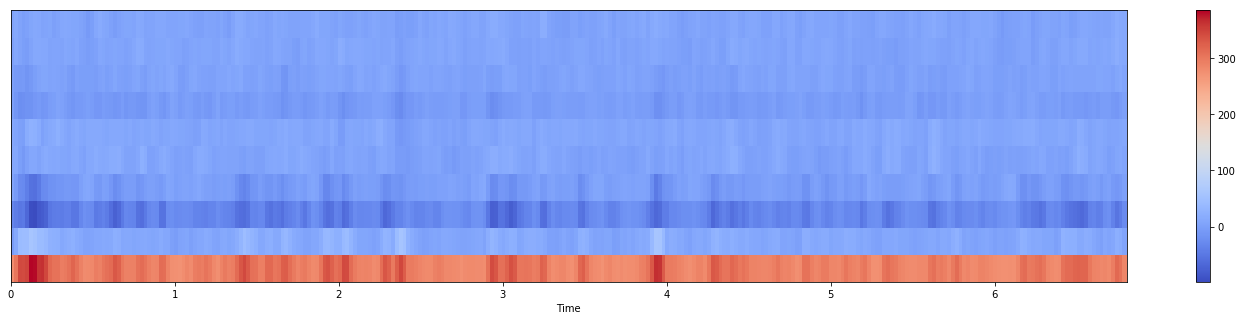

In [5]:
plot_mfcc(librosa.feature.mfcc(acoustic_data[:CHUNK_SIZE], n_mfcc=n_mfcc, sr=sample_rate))

Splitting the entire data into chunks of 150000 records size. Create a dataframe with the single MFCC features + time_to_failure.

In [6]:
import librosa, librosa.display

data_chunks = list(chunks(seismic_data, n=CHUNK_SIZE))
    
mfcc_ttf_map = {}    
for chunk in data_chunks:
    data = chunk.acoustic_data.values.astype('float32')
    data = denoise(data)
       
    mfcc_chunk = librosa.feature.mfcc(data, n_mfcc=n_mfcc, sr=sample_rate)
    mfcc_chunk_mean = mfcc_chunk.mean(axis=1)    
    
    for i, each_mfcc_mean in enumerate(mfcc_chunk_mean):    
        key = 'mfcc_{}'.format(i)
        if key not in mfcc_ttf_map:
            mfcc_ttf_map[key] = []
        mfcc_ttf_map[key].append(each_mfcc_mean)

    key = 'time_to_failure'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []        
    mfcc_ttf_map[key].append(chunk.time_to_failure.iloc[-1])
        
mfcc_ttf_df = pd.DataFrame(mfcc_ttf_map)

Plot the individual MFCC features with the time_to_failure line to see the realization of the MFCC features for the time event.

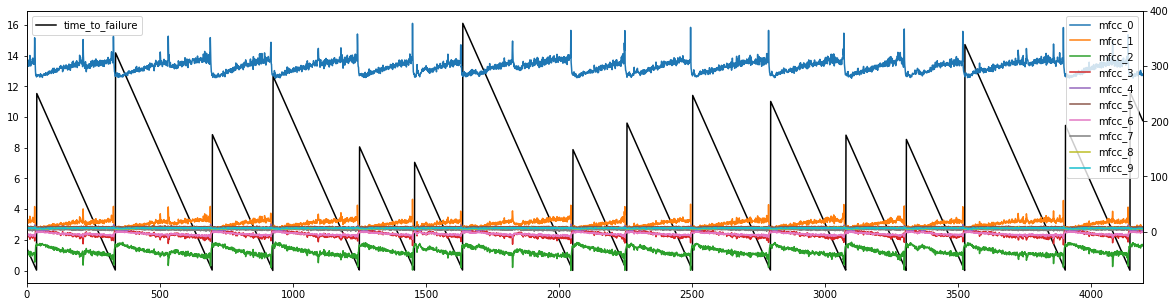

In [7]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)
plt.show()

As you can see from this diagram there is a clear relation between the peaks of some MFCC features and the occurrence of the earthquake.

#### Do PCA

Reduce the MFCC features per PCA to currently only 6 features.

In [8]:
from sklearn.decomposition import PCA

mfcc_data = mfcc_ttf_df.drop(['time_to_failure'], axis=1)

pca = PCA(n_components=6, svd_solver='full', whiten=False, random_state=seed).fit(mfcc_data)
reduced_data = pca.transform(mfcc_data)

reduced_data_frame = pd.DataFrame(reduced_data)
reduced_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

#### After PCA

Plot the feature created by the PCA against the earthquake timeline.

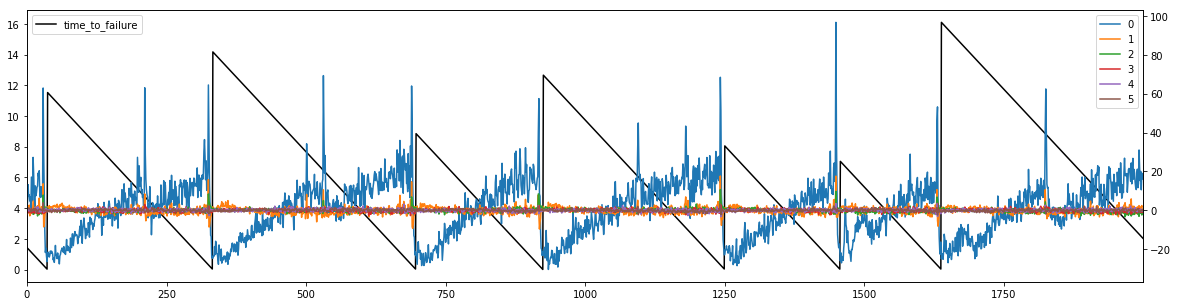

In [9]:
import scipy
from scipy.signal import savgol_filter

fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

from sklearn import preprocessing
from scipy import stats

data = reduced_data_frame.drop(['time_to_failure'], axis=1)

reduced_data_frame['time_to_failure'][:2000].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
data[:2000].plot(ax=ax2, legend=True)
plt.show()

Create the training data with the new features.

In [10]:
preprocessed_data_frame = pd.DataFrame(data)
preprocessed_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

preprocessed_data_frame

,0,1,2,3,4,5,time_to_failure
0,1.234688384943315,-2.315620948903728,-0.771975909426706,-0.665583735816351,0.556459531406330,0.143728864295032,1.430797219276428
1,4.234255911963687,-1.262736158678655,0.109400758430627,-0.670894046533694,0.306352378930641,0.738328947643235,1.391498923301697
2,13.196837864630819,0.999852183553075,-1.092597522226239,-0.124243162030297,0.925256531722623,0.748409477675186,1.353196144104004
3,7.210749491495450,1.102703160248756,-0.770556296635165,-1.296353763498308,-0.348508026485837,1.228785273716540,1.313797831535339
4,7.951667556875964,2.663803573982814,-1.022688145705476,-0.060637765428431,-0.274798854373434,0.922322916377270,1.274399518966675
5,4.830828047500626,-2.810389147022426,0.257004054539959,0.270976178837758,1.038605253063897,0.673667464402064,1.236096739768982
6,6.881952116571922,-2.584528533710952,0.601529010841915,-0.489404711973520,0.862879572621038,0.134221308176430,1.196798443794250
7,1.019794853010644,0.786282807895738,-0.649508440954145,-0.897794684482610,-0.256710182605614,-0.779866381912866,1.158495664596558
8,17.102978075760891,0.732841282106084,-0.926235351648555,-1.486384824617602,-0.459181371370208,0.906922275165161,1.119097352027893
9,10.891749601050668,0.113872204888465,-0.833806778019642,-0.887341426811321,-0.288703308881484,-0.498365867200710,1.079699039459229


### Visualize Testfiles

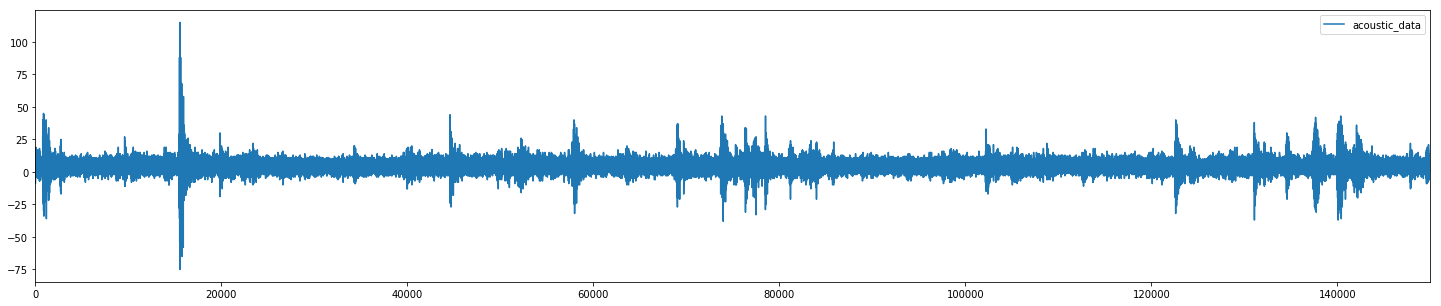

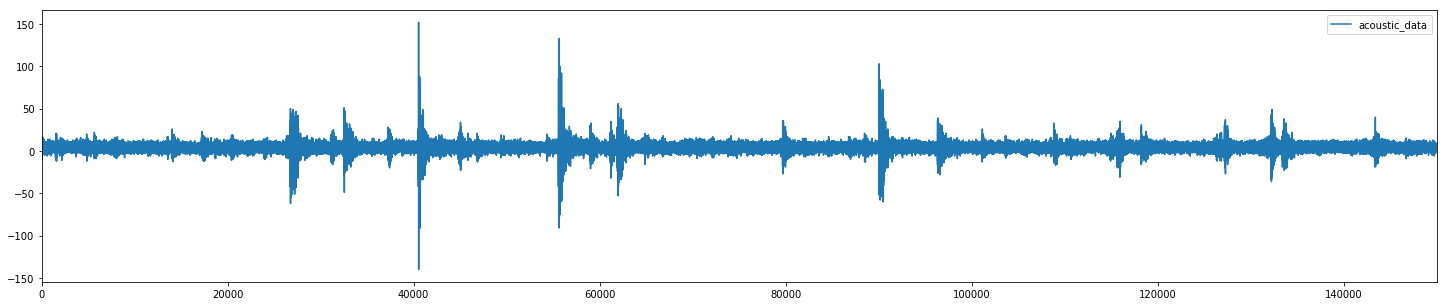

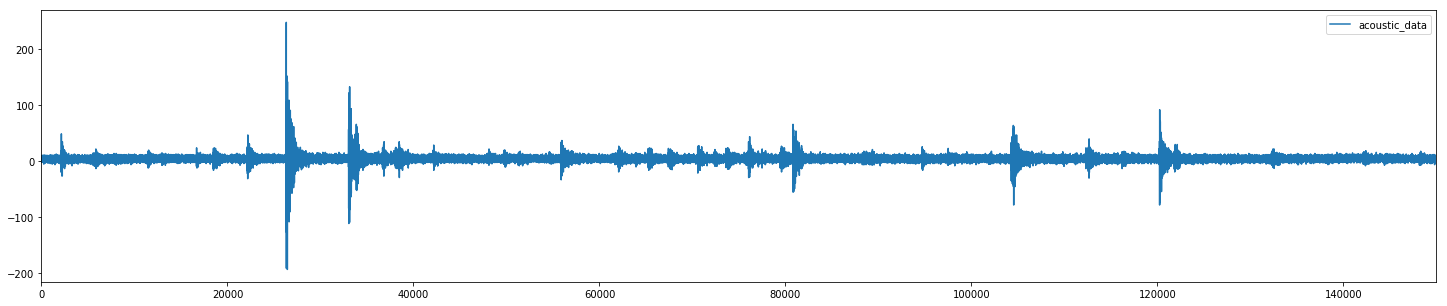

In [11]:
plot_testfile(test_file_dir, n_samples=3)

## Train / Test split

In [12]:
from sklearn.model_selection import train_test_split

X = preprocessed_data_frame.drop(['time_to_failure'], axis=1).values
y = preprocessed_data_frame['time_to_failure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Benchmark

Method to print the score.

In [13]:
def print_scores(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)    
    print('Cross Validation scores: {}'.format(abs(scores)))
    print('Average score: {}'.format(abs(scores.mean())))

In [14]:
def print_mean_absolute_error(model):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print('Average score (MAE): {}'.format(mae))

Use a K-Nearest Neighbor to obtain a reference/benchmark score.

In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

print_scores(knn, X_test, y_test)
print_mean_absolute_error(knn)

Cross Validation scores: [2.22600853 2.09111244 2.1757588  2.18556429 2.1871447 ]
Average score: 2.17311775178281
Average score (MAE): 2.155980882968607


## Data Preprocessing

Method for preprocessing the data read from the test files. This method is to ensure that the input data for the final model matches the data format that has been trained.

In [16]:
def extract_features(seismic_data):
    data = denoise(seismic_data)
    mfcc = librosa.feature.mfcc(data, n_mfcc=n_mfcc, sr=sample_rate)    
    mfcc_mean = mfcc.mean(axis=1)
    
    feature_map = {}    
    
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'f{}'.format(i)
        if key not in feature_map:
            feature_map[key] = []
        feature_map[key].append(each_mfcc_mean)    
    
    reduced = pca.transform(pd.DataFrame(feature_map))
    return reduced

## Implementation

Method for writing the submission file for transmission to Kaggle.

In [17]:
def write_submission(output_file, model, isRNN=False):
    test_files = resolve_csv_files(test_file_dir)    
    
    with open(output_file, 'w', newline='') as outcsv:
        writer = csv.DictWriter(outcsv, fieldnames = ['seg_id', 'time_to_failure'])
        writer.writeheader()
        
        for file in tqdm(test_files[:10]):
            seismic_test_data  = pd.read_csv(file, dtype={'acoustic_data': np.float32})
            features = extract_features(seismic_test_data.acoustic_data.values.astype('float32')) 
            if isRNN:
                features = np.reshape(features, (features.shape[0], 1, features.shape[1]))
            
            prediction = model.predict(features)[0]
            
            if isRNN:
                prediction = prediction[0]
            
            writer.writerow({'seg_id': stem_filename(file), 'time_to_failure': prediction})

In [18]:
write_submission('./submission_knn.csv', knn)

Create a pipeline with multiple parameters to determine the best model using RandomizedSearchCV.

In [19]:
from sklearn import pipeline, metrics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

est = pipeline.Pipeline([
        ('xgb', XGBRegressor(silent=True)),
])

params = {
    'xgb__learning_rate': [0.003, 0.005, 0.01, 0.05, 0.1],
    'xgb__min_child_weight': [5, 6, 7, 8, 9, 10, 11, 12],
    'xgb__subsample': [0.5, 0.7, 0.9],
    'xgb__colsample_bytree': [0.5, 0.7, 0.9],
    'xgb__max_depth': [1, 3, 5, 7, 9, 11],
    'xgb__n_estimators': [10, 50, 100, 150],
}

cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=seed)

search = RandomizedSearchCV(estimator=est, 
                            param_distributions=params, scoring='neg_mean_absolute_error', random_state=seed,                             
                            n_iter=100, cv=cv_sets, verbose=1, n_jobs=1, return_train_score=True)
                            

search.fit(X_train, y_train)
print(search.best_estimator_)

print_scores(search.best_estimator_, X_test, y_test)
print_mean_absolute_error(search.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  4.7min finished


Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))])
Cross Validation scores: [2.10864751 1.97164695 2.12984933 2.16237627 1.97732585]
Average score: 2.069969181446493
Average score (MAE): 2.025977824479386


In [20]:
write_submission('./submission_xgb.csv', search.best_estimator_)

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import Adam, Adadelta, SGD, RMSprop, Nadam
from keras import losses
from keras.callbacks import TensorBoard
import time

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(48, return_sequences=True, input_shape=(None,6)))
model.add(LSTM(36, return_sequences=True))
model.add(GaussianNoise(0.2))
model.add(Dropout(0.4))
model.add(LSTM(32))
model.add(GaussianNoise(0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation="relu"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])
             
now = time.strftime("%Y%m%d_%H%M%S")    
tensorboard_callback = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)    

model.fit(X_train_reshape, y_train,
              epochs=200,
              batch_size=128,
              validation_split=0.05,              
              verbose=1,
              callbacks=[tensorboard_callback]
            )
              
print(model.summary())
score = model.evaluate(X_test_reshape, y_test, batch_size=128)

Using TensorFlow backend.


Train on 3188 samples, validate on 168 samples
Epoch 1/200
3188/3188 [==============================] - ETA: 29s - loss: 5.5259 - mean_absolute_error: 5.52 - ETA: 5s - loss: 5.5213 - mean_absolute_error: 5.5213 - ETA: 2s - loss: 5.5267 - mean_absolute_error: 5.526 - ETA: 1s - loss: 5.5494 - mean_absolute_error: 5.549 - ETA: 0s - loss: 5.5634 - mean_absolute_error: 5.563 - ETA: 0s - loss: 5.5303 - mean_absolute_error: 5.530 - 2s 529us/step - loss: 5.4815 - mean_absolute_error: 5.4815 - val_loss: 5.1020 - val_mean_absolute_error: 5.1020
Epoch 2/200
3188/3188 [==============================] - ETA: 0s - loss: 5.2816 - mean_absolute_error: 5.281 - ETA: 0s - loss: 5.2398 - mean_absolute_error: 5.239 - ETA: 0s - loss: 5.2368 - mean_absolute_error: 5.236 - ETA: 0s - loss: 5.1786 - mean_absolute_error: 5.178 - ETA: 0s - loss: 5.0454 - mean_absolute_error: 5.045 - ETA: 0s - loss: 4.9923 - mean_absolute_error: 4.992 - 0s 119us/step - loss: 4.8893 - mean_absolute_error: 4.8893 - val_loss: 4.4662 

3188/3188 [==============================] - ETA: 0s - loss: 2.3147 - mean_absolute_error: 2.314 - ETA: 0s - loss: 2.2405 - mean_absolute_error: 2.240 - ETA: 0s - loss: 2.1567 - mean_absolute_error: 2.156 - ETA: 0s - loss: 2.1952 - mean_absolute_error: 2.195 - ETA: 0s - loss: 2.2183 - mean_absolute_error: 2.218 - ETA: 0s - loss: 2.2166 - mean_absolute_error: 2.216 - ETA: 0s - loss: 2.2184 - mean_absolute_error: 2.218 - 0s 131us/step - loss: 2.2136 - mean_absolute_error: 2.2136 - val_loss: 2.1653 - val_mean_absolute_error: 2.1653
Epoch 15/200
3188/3188 [==============================] - ETA: 0s - loss: 2.4976 - mean_absolute_error: 2.497 - ETA: 0s - loss: 2.1993 - mean_absolute_error: 2.199 - ETA: 0s - loss: 2.2315 - mean_absolute_error: 2.231 - ETA: 0s - loss: 2.2500 - mean_absolute_error: 2.250 - ETA: 0s - loss: 2.2130 - mean_absolute_error: 2.213 - ETA: 0s - loss: 2.2058 - mean_absolute_error: 2.205 - ETA: 0s - loss: 2.2368 - mean_absolute_error: 2.236 - 0s 127us/step - loss: 2.2315 

3188/3188 [==============================] - ETA: 0s - loss: 2.1818 - mean_absolute_error: 2.181 - ETA: 0s - loss: 2.1657 - mean_absolute_error: 2.165 - ETA: 0s - loss: 2.1371 - mean_absolute_error: 2.137 - ETA: 0s - loss: 2.1577 - mean_absolute_error: 2.157 - ETA: 0s - loss: 2.1364 - mean_absolute_error: 2.136 - ETA: 0s - loss: 2.1551 - mean_absolute_error: 2.155 - ETA: 0s - loss: 2.1626 - mean_absolute_error: 2.162 - ETA: 0s - loss: 2.1705 - mean_absolute_error: 2.170 - ETA: 0s - loss: 2.1770 - mean_absolute_error: 2.177 - ETA: 0s - loss: 2.1701 - mean_absolute_error: 2.170 - ETA: 0s - loss: 2.1643 - mean_absolute_error: 2.164 - ETA: 0s - loss: 2.1702 - mean_absolute_error: 2.170 - 1s 237us/step - loss: 2.1627 - mean_absolute_error: 2.1627 - val_loss: 2.0877 - val_mean_absolute_error: 2.0877
Epoch 27/200
3188/3188 [==============================] - ETA: 0s - loss: 1.9588 - mean_absolute_error: 1.958 - ETA: 0s - loss: 2.1243 - mean_absolute_error: 2.124 - ETA: 0s - loss: 2.0473 - mean

3188/3188 [==============================] - ETA: 0s - loss: 2.0627 - mean_absolute_error: 2.062 - ETA: 0s - loss: 1.9818 - mean_absolute_error: 1.981 - ETA: 0s - loss: 2.1070 - mean_absolute_error: 2.107 - ETA: 0s - loss: 2.0957 - mean_absolute_error: 2.095 - ETA: 0s - loss: 2.0885 - mean_absolute_error: 2.088 - ETA: 0s - loss: 2.1258 - mean_absolute_error: 2.125 - ETA: 0s - loss: 2.1294 - mean_absolute_error: 2.129 - 0s 133us/step - loss: 2.1292 - mean_absolute_error: 2.1292 - val_loss: 2.0480 - val_mean_absolute_error: 2.0480
Epoch 41/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0903 - mean_absolute_error: 2.090 - ETA: 0s - loss: 2.0506 - mean_absolute_error: 2.050 - ETA: 0s - loss: 2.0742 - mean_absolute_error: 2.074 - ETA: 0s - loss: 2.0782 - mean_absolute_error: 2.078 - ETA: 0s - loss: 2.1284 - mean_absolute_error: 2.128 - ETA: 0s - loss: 2.1226 - mean_absolute_error: 2.122 - ETA: 0s - loss: 2.1124 - mean_absolute_error: 2.112 - 0s 122us/step - loss: 2.1141 

3188/3188 [==============================] - ETA: 0s - loss: 2.0717 - mean_absolute_error: 2.071 - ETA: 0s - loss: 2.0164 - mean_absolute_error: 2.016 - ETA: 0s - loss: 2.1130 - mean_absolute_error: 2.113 - ETA: 0s - loss: 2.1109 - mean_absolute_error: 2.110 - ETA: 0s - loss: 2.0762 - mean_absolute_error: 2.076 - ETA: 0s - loss: 2.0598 - mean_absolute_error: 2.059 - 0s 116us/step - loss: 2.0801 - mean_absolute_error: 2.0801 - val_loss: 2.0200 - val_mean_absolute_error: 2.0200
Epoch 57/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0250 - mean_absolute_error: 2.025 - ETA: 0s - loss: 2.0920 - mean_absolute_error: 2.092 - ETA: 0s - loss: 2.1732 - mean_absolute_error: 2.173 - ETA: 0s - loss: 2.1611 - mean_absolute_error: 2.161 - ETA: 0s - loss: 2.1396 - mean_absolute_error: 2.139 - ETA: 0s - loss: 2.1328 - mean_absolute_error: 2.132 - 0s 119us/step - loss: 2.1006 - mean_absolute_error: 2.1006 - val_loss: 2.0128 - val_mean_absolute_error: 2.0128
Epoch 58/200
3188/3188 [=

3188/3188 [==============================] - ETA: 0s - loss: 1.9460 - mean_absolute_error: 1.946 - ETA: 0s - loss: 2.0874 - mean_absolute_error: 2.087 - ETA: 0s - loss: 2.0247 - mean_absolute_error: 2.024 - ETA: 0s - loss: 2.0452 - mean_absolute_error: 2.045 - ETA: 0s - loss: 2.0481 - mean_absolute_error: 2.048 - ETA: 0s - loss: 2.0622 - mean_absolute_error: 2.062 - 0s 123us/step - loss: 2.0635 - mean_absolute_error: 2.0635 - val_loss: 2.0072 - val_mean_absolute_error: 2.0072
Epoch 73/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1391 - mean_absolute_error: 2.139 - ETA: 0s - loss: 2.0921 - mean_absolute_error: 2.092 - ETA: 0s - loss: 2.0792 - mean_absolute_error: 2.079 - ETA: 0s - loss: 2.0758 - mean_absolute_error: 2.075 - ETA: 0s - loss: 2.0630 - mean_absolute_error: 2.063 - ETA: 0s - loss: 2.0816 - mean_absolute_error: 2.081 - 0s 118us/step - loss: 2.0752 - mean_absolute_error: 2.0752 - val_loss: 2.0058 - val_mean_absolute_error: 2.0058
Epoch 74/200
3188/3188 [=

3188/3188 [==============================] - ETA: 0s - loss: 2.0717 - mean_absolute_error: 2.071 - ETA: 0s - loss: 1.9960 - mean_absolute_error: 1.996 - ETA: 0s - loss: 2.0565 - mean_absolute_error: 2.056 - ETA: 0s - loss: 2.0919 - mean_absolute_error: 2.091 - ETA: 0s - loss: 2.0662 - mean_absolute_error: 2.066 - ETA: 0s - loss: 2.0677 - mean_absolute_error: 2.067 - ETA: 0s - loss: 2.0583 - mean_absolute_error: 2.058 - 0s 127us/step - loss: 2.0603 - mean_absolute_error: 2.0603 - val_loss: 2.0462 - val_mean_absolute_error: 2.0462
Epoch 89/200
3188/3188 [==============================] - ETA: 0s - loss: 1.8504 - mean_absolute_error: 1.850 - ETA: 0s - loss: 2.0066 - mean_absolute_error: 2.006 - ETA: 0s - loss: 2.0191 - mean_absolute_error: 2.019 - ETA: 0s - loss: 2.0359 - mean_absolute_error: 2.035 - ETA: 0s - loss: 2.0697 - mean_absolute_error: 2.069 - ETA: 0s - loss: 2.0539 - mean_absolute_error: 2.053 - ETA: 0s - loss: 2.0602 - mean_absolute_error: 2.060 - 0s 131us/step - loss: 2.0557 

3188/3188 [==============================] - ETA: 0s - loss: 1.9219 - mean_absolute_error: 1.921 - ETA: 0s - loss: 2.0370 - mean_absolute_error: 2.037 - ETA: 0s - loss: 2.0335 - mean_absolute_error: 2.033 - ETA: 0s - loss: 2.0065 - mean_absolute_error: 2.006 - ETA: 0s - loss: 2.0280 - mean_absolute_error: 2.028 - ETA: 0s - loss: 2.0529 - mean_absolute_error: 2.052 - ETA: 0s - loss: 2.0443 - mean_absolute_error: 2.044 - ETA: 0s - loss: 2.0541 - mean_absolute_error: 2.054 - 0s 142us/step - loss: 2.0461 - mean_absolute_error: 2.0461 - val_loss: 2.0191 - val_mean_absolute_error: 2.0191
Epoch 103/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1231 - mean_absolute_error: 2.123 - ETA: 0s - loss: 2.1649 - mean_absolute_error: 2.164 - ETA: 0s - loss: 2.0739 - mean_absolute_error: 2.073 - ETA: 0s - loss: 2.0711 - mean_absolute_error: 2.071 - ETA: 0s - loss: 2.0911 - mean_absolute_error: 2.091 - ETA: 0s - loss: 2.0988 - mean_absolute_error: 2.098 - ETA: 0s - loss: 2.0917 - mea

3188/3188 [==============================] - ETA: 0s - loss: 1.8607 - mean_absolute_error: 1.860 - ETA: 0s - loss: 1.9494 - mean_absolute_error: 1.949 - ETA: 0s - loss: 1.9554 - mean_absolute_error: 1.955 - ETA: 0s - loss: 1.9810 - mean_absolute_error: 1.981 - ETA: 0s - loss: 2.0077 - mean_absolute_error: 2.007 - ETA: 0s - loss: 2.0104 - mean_absolute_error: 2.010 - 0s 114us/step - loss: 2.0243 - mean_absolute_error: 2.0243 - val_loss: 2.0097 - val_mean_absolute_error: 2.0097
Epoch 118/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1936 - mean_absolute_error: 2.193 - ETA: 0s - loss: 1.9229 - mean_absolute_error: 1.922 - ETA: 0s - loss: 1.9686 - mean_absolute_error: 1.968 - ETA: 0s - loss: 2.0396 - mean_absolute_error: 2.039 - ETA: 0s - loss: 2.0307 - mean_absolute_error: 2.030 - ETA: 0s - loss: 2.0214 - mean_absolute_error: 2.021 - ETA: 0s - loss: 2.0184 - mean_absolute_error: 2.018 - 0s 137us/step - loss: 2.0394 - mean_absolute_error: 2.0394 - val_loss: 2.0126 - va

3188/3188 [==============================] - ETA: 0s - loss: 2.1192 - mean_absolute_error: 2.119 - ETA: 0s - loss: 2.0181 - mean_absolute_error: 2.018 - ETA: 0s - loss: 1.9897 - mean_absolute_error: 1.989 - ETA: 0s - loss: 2.0305 - mean_absolute_error: 2.030 - ETA: 0s - loss: 2.0600 - mean_absolute_error: 2.060 - ETA: 0s - loss: 2.0349 - mean_absolute_error: 2.034 - ETA: 0s - loss: 2.0206 - mean_absolute_error: 2.020 - 0s 129us/step - loss: 2.0186 - mean_absolute_error: 2.0186 - val_loss: 2.0366 - val_mean_absolute_error: 2.0366
Epoch 134/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2079 - mean_absolute_error: 2.207 - ETA: 0s - loss: 2.0059 - mean_absolute_error: 2.005 - ETA: 0s - loss: 2.0024 - mean_absolute_error: 2.002 - ETA: 0s - loss: 2.0102 - mean_absolute_error: 2.010 - ETA: 0s - loss: 2.0607 - mean_absolute_error: 2.060 - ETA: 0s - loss: 2.0461 - mean_absolute_error: 2.046 - 0s 118us/step - loss: 2.0257 - mean_absolute_error: 2.0257 - val_loss: 2.0135 - va

3188/3188 [==============================] - ETA: 0s - loss: 2.0378 - mean_absolute_error: 2.037 - ETA: 0s - loss: 1.9361 - mean_absolute_error: 1.936 - ETA: 0s - loss: 1.9867 - mean_absolute_error: 1.986 - ETA: 0s - loss: 2.0049 - mean_absolute_error: 2.004 - ETA: 0s - loss: 2.0075 - mean_absolute_error: 2.007 - ETA: 0s - loss: 2.0229 - mean_absolute_error: 2.022 - 0s 117us/step - loss: 2.0051 - mean_absolute_error: 2.0051 - val_loss: 2.0350 - val_mean_absolute_error: 2.0350
Epoch 150/200
3188/3188 [==============================] - ETA: 0s - loss: 1.8764 - mean_absolute_error: 1.876 - ETA: 0s - loss: 1.9546 - mean_absolute_error: 1.954 - ETA: 0s - loss: 2.0262 - mean_absolute_error: 2.026 - ETA: 0s - loss: 2.0125 - mean_absolute_error: 2.012 - ETA: 0s - loss: 2.0057 - mean_absolute_error: 2.005 - ETA: 0s - loss: 2.0080 - mean_absolute_error: 2.008 - 0s 117us/step - loss: 2.0400 - mean_absolute_error: 2.0400 - val_loss: 2.0237 - val_mean_absolute_error: 2.0237
Epoch 151/200
3188/3188 

3188/3188 [==============================] - ETA: 0s - loss: 2.4749 - mean_absolute_error: 2.474 - ETA: 0s - loss: 2.0965 - mean_absolute_error: 2.096 - ETA: 0s - loss: 2.0753 - mean_absolute_error: 2.075 - ETA: 0s - loss: 2.0134 - mean_absolute_error: 2.013 - ETA: 0s - loss: 1.9991 - mean_absolute_error: 1.999 - ETA: 0s - loss: 2.0230 - mean_absolute_error: 2.023 - 0s 118us/step - loss: 2.0180 - mean_absolute_error: 2.0180 - val_loss: 2.0421 - val_mean_absolute_error: 2.0421
Epoch 166/200
3188/3188 [==============================] - ETA: 0s - loss: 1.9038 - mean_absolute_error: 1.903 - ETA: 0s - loss: 1.9514 - mean_absolute_error: 1.951 - ETA: 0s - loss: 1.9848 - mean_absolute_error: 1.984 - ETA: 0s - loss: 1.9888 - mean_absolute_error: 1.988 - ETA: 0s - loss: 1.9810 - mean_absolute_error: 1.981 - ETA: 0s - loss: 1.9898 - mean_absolute_error: 1.989 - 0s 123us/step - loss: 2.0069 - mean_absolute_error: 2.0069 - val_loss: 2.0768 - val_mean_absolute_error: 2.0768
Epoch 167/200
3188/3188 

3188/3188 [==============================] - ETA: 0s - loss: 1.9112 - mean_absolute_error: 1.911 - ETA: 0s - loss: 1.9810 - mean_absolute_error: 1.981 - ETA: 0s - loss: 2.0260 - mean_absolute_error: 2.026 - ETA: 0s - loss: 1.9964 - mean_absolute_error: 1.996 - ETA: 0s - loss: 1.9576 - mean_absolute_error: 1.957 - ETA: 0s - loss: 1.9544 - mean_absolute_error: 1.954 - ETA: 0s - loss: 1.9596 - mean_absolute_error: 1.959 - 0s 121us/step - loss: 1.9685 - mean_absolute_error: 1.9685 - val_loss: 2.0486 - val_mean_absolute_error: 2.0486
Epoch 182/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0026 - mean_absolute_error: 2.002 - ETA: 0s - loss: 1.9345 - mean_absolute_error: 1.934 - ETA: 0s - loss: 1.9884 - mean_absolute_error: 1.988 - ETA: 0s - loss: 1.9666 - mean_absolute_error: 1.966 - ETA: 0s - loss: 1.9678 - mean_absolute_error: 1.967 - ETA: 0s - loss: 1.9636 - mean_absolute_error: 1.963 - ETA: 0s - loss: 1.9752 - mean_absolute_error: 1.975 - 0s 124us/step - loss: 1.9793

3188/3188 [==============================] - ETA: 0s - loss: 2.2387 - mean_absolute_error: 2.238 - ETA: 0s - loss: 2.0089 - mean_absolute_error: 2.008 - ETA: 0s - loss: 1.9613 - mean_absolute_error: 1.961 - ETA: 0s - loss: 1.9673 - mean_absolute_error: 1.967 - ETA: 0s - loss: 1.9683 - mean_absolute_error: 1.968 - ETA: 0s - loss: 1.9987 - mean_absolute_error: 1.998 - 0s 118us/step - loss: 1.9951 - mean_absolute_error: 1.9951 - val_loss: 2.0443 - val_mean_absolute_error: 2.0443
Epoch 198/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0235 - mean_absolute_error: 2.023 - ETA: 0s - loss: 2.0213 - mean_absolute_error: 2.021 - ETA: 0s - loss: 2.0559 - mean_absolute_error: 2.055 - ETA: 0s - loss: 2.0724 - mean_absolute_error: 2.072 - ETA: 0s - loss: 2.0485 - mean_absolute_error: 2.048 - ETA: 0s - loss: 2.0163 - mean_absolute_error: 2.016 - 0s 115us/step - loss: 2.0048 - mean_absolute_error: 2.0048 - val_loss: 2.0371 - val_mean_absolute_error: 2.0371
Epoch 199/200
3188/3188 

In [22]:
write_submission('./submission_rnn.csv', model, isRNN=True)